In [1]:
%matplotlib inline

In [21]:
import re
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

# Reading data

In [22]:
def data_files(dir_path='eyes'):
    for fname in os.listdir(dir_path):
        if fname.endswith('.json'):
            yield os.path.join(dir_path, fname)

In [31]:
SIZE_THRESHOLD = 90

def crop(data):
    return data[:SIZE_THRESHOLD,:SIZE_THRESHOLD,:]

def dataset():
    data = {}
    for file in data_files():
        m = re.match(r'.*/(\w+)_(\w+)-(\w+)_(\w+)_(\d+)\.json', file)
        person, coordY, coordX, eye, timestamp = m.groups()
        
        content = None
        with open(file, 'r') as f:
            content = "".join(f.readlines())
            
        parsed_json = json.loads(content)
        pixels = np.array(parsed_json, dtype=np.uint8)
        
        if pixels.shape[0] >= SIZE_THRESHOLD:
            if not timestamp in data:
                data[timestamp] = { 'meta': (person, coordY, coordX, timestamp), 'pixels': {} }
            data[timestamp]['pixels'][eye] = pixels
    
    meta, X = [], []
    
    j = 0
    
    for timestamp, d in data.items():
        if len(d['pixels']) > 1 and j != 2:
            first = crop(d['pixels']['first'])
            second = crop(d['pixels']['second'])
                          
            x = np.concatenate((first, second), axis=1)
            meta.append(d['meta'])
            X.append(x)
        j += 1
                
    meta = pd.DataFrame(meta, columns=["person", "coordY", "coordX", "timestamp"])
    return meta, np.array(X)

In [32]:
meta_df, data = dataset()

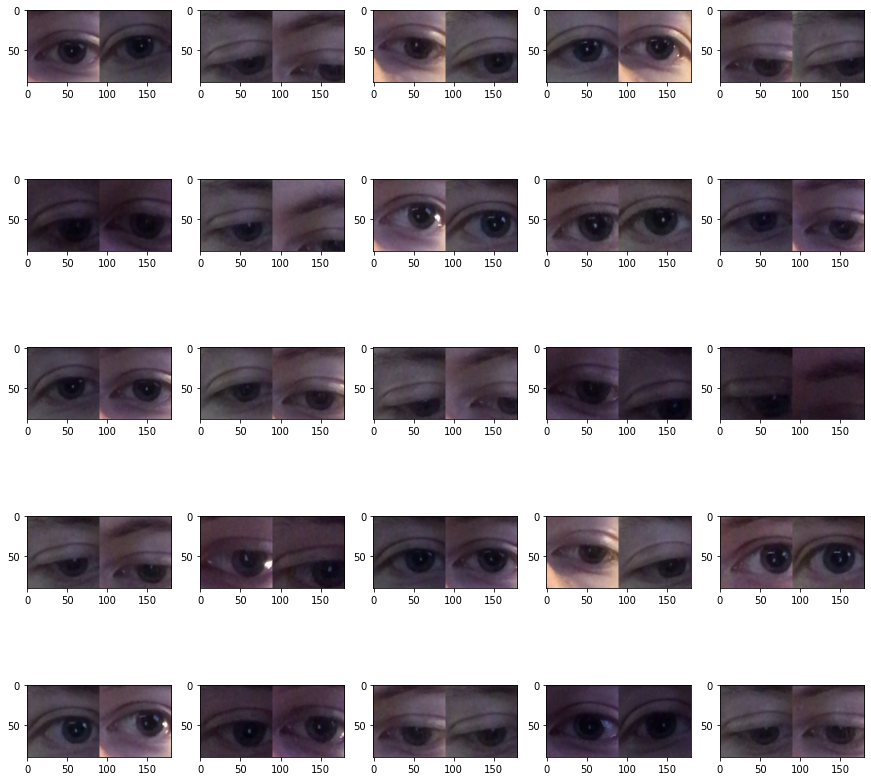

In [34]:
plt.figure(figsize=(15,15)) 

size = 5
for i, image in enumerate(data[:(size*size)]):
    try: 
        plt.subplot(size, size, i+1)
        plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    except Exception as e:
        print(e)
        pass
    
plt.savefig('2_eyes_subset.png')

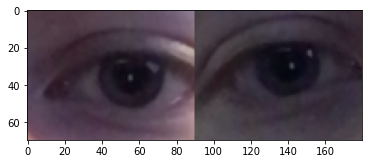

(70, 180, 4)

In [129]:
plt.imshow(data[0][15:85,:,:])
plt.show()
data[0][15:85,:,:].shape

In [137]:
def crop(image):
    return image[15:85, :, :]

def augment_single(image):
    s = SIZE_THRESHOLD
#     image = tf.image.resize_with_crop_or_pad(image, s+50, s+10)
#     image = tf.image.random_crop(image, [s, s, 4])
    image = crop(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image

def augment(eyes):
    first = eyes[:,:SIZE_THRESHOLD,:]
    second = eyes[:,SIZE_THRESHOLD:,:]
    
    first = augment_single(first)
    second = augment_single(second)
        
    return np.concatenate((first, second), axis=1)

In [131]:
from random import shuffle

def augment_set(X, y, augmentations_per_sample=2):
    aX, ay = [], []
    
    for _x, _y in zip(X, y):
        for _ in range(augmentations_per_sample):
            aX.append(augment(_x))
            ay.append(_y)
            
    tmp = list(zip(aX, ay))
    shuffle(tmp)
    aX, ay = zip(*tmp)
            
    return np.concatenate([X, np.array(aX)]), np.concatenate([y, np.asmatrix(np.array(ay))])

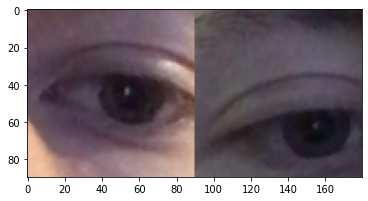

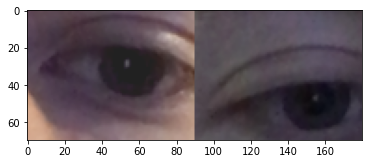

In [132]:
j = 2

plt.imshow(data[j])
plt.show()

plt.imshow(augment(data[j]))
plt.show()

# Classification Model

In [13]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.1.0


In [108]:
X_train, X_test, meta_train, meta_test = train_test_split(data, meta_df, test_size=0.4, random_state=42)
X_val, X_test, meta_val, meta_test = train_test_split(X_test, meta_test, test_size=0.5, random_state=42)

def get_label(meta):
    t = np.zeros(len(meta))
    t[meta['coordX'] == 'left'] = 0
    t[meta['coordX'] == 'mid'] = 1
    t[meta['coordX'] == 'right'] = 2
    return t
    
y_train, y_val, y_test = get_label(meta_train), get_label(meta_val), get_label(meta_test)

In [110]:
def build_classification_model():
    ch = 4
    model = Sequential([
        Conv2D(16, ch, padding='same', activation='relu', input_shape=(SIZE_TRESHOLD, SIZE_TRESHOLD, ch)),
        MaxPooling2D(),
        Conv2D(32, ch, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(64, ch, padding='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(3)
    ])
    
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    return model

In [111]:
model = build_classification_model()

In [97]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 95, 95, 16)        1040      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 47, 47, 32)        8224      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 23, 23, 64)        32832     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 7744)             

In [105]:
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val))

Train on 237 samples, validate on 79 samples
Epoch 1/15
237/237 [==============================] - 1s 5ms/sample - loss: 1.0309 - accuracy: 0.5232 - val_loss: 1.0419 - val_accuracy: 0.5063
Epoch 2/15
237/237 [==============================] - 1s 4ms/sample - loss: 1.0097 - accuracy: 0.4895 - val_loss: 1.0299 - val_accuracy: 0.4684
Epoch 3/15
237/237 [==============================] - 1s 4ms/sample - loss: 1.0060 - accuracy: 0.5316 - val_loss: 1.0188 - val_accuracy: 0.4810
Epoch 4/15
237/237 [==============================] - 1s 4ms/sample - loss: 0.9981 - accuracy: 0.5274 - val_loss: 0.9916 - val_accuracy: 0.4810
Epoch 5/15
237/237 [==============================] - 1s 5ms/sample - loss: 0.9625 - accuracy: 0.5485 - val_loss: 0.9355 - val_accuracy: 0.5949
Epoch 6/15
237/237 [==============================] - 1s 5ms/sample - loss: 0.9145 - accuracy: 0.5401 - val_loss: 0.9602 - val_accuracy: 0.5443
Epoch 7/15
237/237 [==============================] - 1s 5ms/sample - loss: 0.8904 - accura

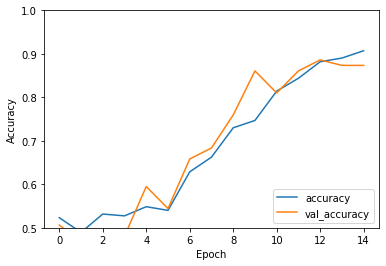

In [106]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [107]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

80/80 - 0s - loss: 0.5170 - accuracy: 0.7375


# Regression Model

In [112]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.2.0


In [133]:
EYE_HEIGHT=70
EYE_WIDTH=90

def build_regression_model():
    ch = 4
    model = Sequential([
        Conv2D(16, ch, padding='same', activation='relu', input_shape=(EYE_HEIGHT, 2*EYE_WIDTH, ch)),
        MaxPooling2D(),
        Conv2D(32, ch, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(64, ch, padding='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(2)
    ])
    
    model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae', 'mse'])
    
    return model

In [134]:
model = build_regression_model()

In [135]:
# size from Dimensions.get('window') on Iphone 6s
WIDTH = 414
HEIGHT = 736

In [139]:
X_train, X_test, meta_train, meta_test = train_test_split(data, meta_df, test_size=0.4, random_state=42)
X_val, X_test, meta_val, meta_test = train_test_split(X_test, meta_test, test_size=0.5, random_state=42)

def get_value(meta):
    x = np.zeros(len(meta))
    y = np.zeros(len(meta))
    x[meta['coordX'] == 'left'] = 0
    x[meta['coordX'] == 'mid'] = WIDTH / 2
    x[meta['coordX'] == 'right'] = WIDTH
    y[meta['coordY'] == 'top'] = 0
    y[meta['coordY'] == 'mid'] = HEIGHT / 2
    y[meta['coordY'] == 'bottom'] = HEIGHT
    
    x = np.asmatrix(x)
    y = np.asmatrix(y)
    
    return np.concatenate([x, y]).T

y_train, y_val, y_test = get_value(meta_train), get_value(meta_val), get_value(meta_test)
X_train, y_train = augment_set(X_train, y_train)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 90 and the array at index 1 has size 70

In [117]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
21/21 [==============================] - 8s 358ms/step - loss: 408337.3750 - mae: 369.0094 - mse: 408337.3750 - val_loss: 62961.2969 - val_mae: 205.7068 - val_mse: 62961.2969
Epoch 2/50
21/21 [==============================] - 5s 257ms/step - loss: 52899.8125 - mae: 188.9169 - mse: 52899.8125 - val_loss: 37749.2500 - val_mae: 166.4052 - val_mse: 37749.2500
Epoch 3/50
21/21 [==============================] - 6s 270ms/step - loss: 29267.4023 - mae: 143.5960 - mse: 29267.4023 - val_loss: 24830.3984 - val_mae: 125.1649 - val_mse: 24830.3984
Epoch 4/50
21/21 [==============================] - 6s 302ms/step - loss: 21779.5234 - mae: 122.7917 - mse: 21779.5234 - val_loss: 19616.5156 - val_mae: 115.9561 - val_mse: 19616.5156
Epoch 5/50
21/21 [==============================] - 6s 281ms/step - loss: 20353.7949 - mae: 118.0855 - mse: 20353.7949 - val_loss: 18129.0293 - val_mae: 110.5958 - val_mse: 18129.0293
Epoch 6/50
21/21 [==============================] - 6s 291ms/step - loss: 2024

21/21 [==============================] - 6s 298ms/step - loss: 1202.2048 - mae: 26.2800 - mse: 1202.2048 - val_loss: 7888.9038 - val_mae: 58.6043 - val_mse: 7888.9038
Epoch 47/50
21/21 [==============================] - 6s 267ms/step - loss: 1285.7446 - mae: 27.4433 - mse: 1285.7446 - val_loss: 7286.1362 - val_mae: 55.1406 - val_mse: 7286.1362
Epoch 48/50
21/21 [==============================] - 5s 247ms/step - loss: 944.6298 - mae: 23.2183 - mse: 944.6298 - val_loss: 6902.1006 - val_mae: 52.6273 - val_mse: 6902.1006
Epoch 49/50
21/21 [==============================] - 6s 273ms/step - loss: 800.0347 - mae: 21.0654 - mse: 800.0347 - val_loss: 6778.5112 - val_mae: 52.9918 - val_mse: 6778.5112
Epoch 50/50
21/21 [==============================] - 7s 347ms/step - loss: 926.3350 - mae: 23.0311 - mse: 926.3350 - val_loss: 7144.8447 - val_mae: 52.6549 - val_mse: 7144.8447


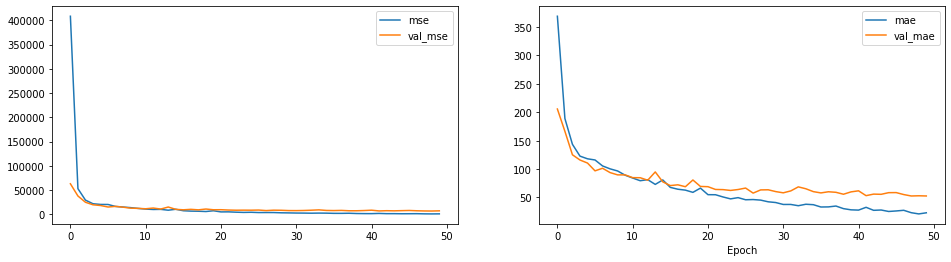

In [119]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

for i, metric in enumerate(['mse', 'mae']):
    axes[i].plot(history.history[metric], label=metric)
    axes[i].plot(history.history[f'val_{metric}'], label = f'val_{metric}')
#     .ylabel(metric)
    axes[i].legend(loc='upper right')

plt.xlabel('Epoch')
plt.show()

In [120]:
model.evaluate(X_test,  y_test, verbose=2)

3/3 - 0s - loss: 6086.8442 - mae: 46.4999 - mse: 6086.8442


[6086.84423828125, 46.49989700317383, 6086.84423828125]

In [52]:
model.save("model_v3", save_format="h5")

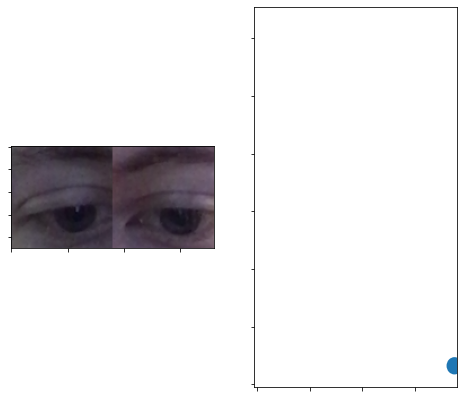

In [56]:
import matplotlib.patches as patches

example = X_test[1]

cx, cy = model.predict(np.array([example]))[0]

cx = max(0, min(cx, WIDTH))
cy = max(0, min(cy, HEIGHT))

fig, axis = plt.subplots(2, figsize=(8,7))

# eye image
ax = plt.subplot(1, 2, 1)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.imshow(example, vmin=0, vmax=255)

# phone screen
circle = patches.Circle((WIDTH - cx, HEIGHT - cy), 30, fill=True)
ax = plt.subplot(1, 2, 2)
ax.add_patch(circle)
plt.xlim((-10, WIDTH + 10))
plt.ylim((-10, HEIGHT + 10))
ax.set_yticklabels([])
ax.set_xticklabels([])


plt.show()

In [58]:
from celluloid import Camera

/home/porcupine/.pyenv/versions/3.7.5/envs/eye-tracker/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/porcupine/.pyenv/versions/3.7.5/envs/eye-tracker/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


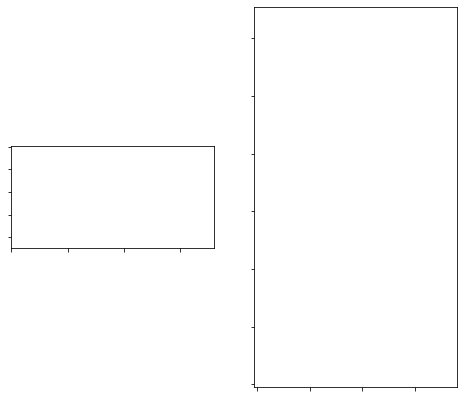

In [60]:
fig, axis = plt.subplots(2, figsize=(8,7))

camera = Camera(fig)

for i in range(10):
    example = X_test[i]

    cx, cy = model.predict(np.array([example]))[0]

    cx = max(0, min(cx, WIDTH))
    cy = max(0, min(cy, HEIGHT))

    # eye image
    ax = plt.subplot(1, 2, 1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.imshow(example, vmin=0, vmax=255)

    # phone screen
    circle = patches.Circle((WIDTH - cx, HEIGHT - cy), 30, fill=True)
    ax = plt.subplot(1, 2, 2)
    ax.add_patch(circle)
    plt.xlim((-10, WIDTH + 10))
    plt.ylim((-10, HEIGHT + 10))
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
    camera.snap()
    

animation = camera.animate()
animation.save('predictions.gif', writer = 'imagemagick', fps=1)